In [1]:
import nltk                                  # Python library for NLP
from nltk.corpus import twitter_samples      # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt              # visualization library
import numpy as np                           # library for scientific computing and matrix operations
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def process_tweet(tweet):
    
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
# remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
# remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
# remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
# remove hashtags
# only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
# tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
             word not in string.punctuation):  # remove punctuation
        # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
    
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [7]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [8]:
# select the lists of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets

# let's see how many tweets we have
print("Number of tweets: ", len(tweets))

Number of tweets:  10000


In [9]:
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [10]:
# create frequency dictionary
freqs = build_freqs(tweets, labels)

In [11]:
Xpos=np.zeros((len(tweets),4))
Xneg=np.zeros((len(tweets),4))

In [19]:
def extract_features(tweet, freqs,flag):
       word_l = process_tweet(tweet)
       x = np.zeros((1, 4))
       x[0,0] = 1
       if flag == 1:
            x[0,3]=1
       else:
            x[0,3]=0
       for word in word_l:
        
        # increment the word count for the positive label 1
            x[0,1] += freqs.get((word, 1.0),0)
        
        # increment the word count for the negative label 0
            x[0,2] += freqs.get((word, 0.0),0)
       return x

In [21]:
import pandas as pd
def dataMaker(all_positive_tweets,all_negative_tweets):
    extracted_pos_feature = []
    for tweet in all_positive_tweets:
        feature = extract_features(tweet,freqs,1)
        extracted_pos_feature.append(feature[0])
        
    extracted_neg_feature = []
    for tweet in all_negative_tweets:
        feature = extract_features(tweet,freqs,0)
        extracted_neg_feature.append(feature[0])
        
    return extracted_pos_feature,extracted_neg_feature
pos,neg = dataMaker(all_positive_tweets,all_negative_tweets)
pos_df = pd.DataFrame(pos)
neg_df = pd.DataFrame(neg)
featured_tweet_data = pd.concat([pos_df,neg_df],axis=0)
featured_tweet_data.head(n=10)

,0,1,2,3
0,1.0,3764.0,72.0,1.0
1,1.0,4464.0,517.0,1.0
2,1.0,3759.0,160.0,1.0
3,1.0,3589.0,4.0,1.0
4,1.0,3915.0,280.0,1.0
5,1.0,3716.0,150.0,1.0
6,1.0,4923.0,646.0,1.0
7,1.0,3965.0,355.0,1.0
8,1.0,789.0,234.0,1.0
9,1.0,342.0,133.0,1.0


In [22]:
print(Xpos.shape)
# split the data into two pieces, one for training and one for testing (validation set) 
train_pos  = all_positive_tweets[:4000]
train_neg  = all_negative_tweets[:4000]

train_x = train_pos + train_neg 

print("Number of tweets: ", len(train_x))

(10000, 4)
Number of tweets:  8000


In [23]:
# Each feature is labeled as bias, positive and negative
X = featured_tweet_data[[0,1,2]].values # Get only the numerical values of the dataframe
Y = featured_tweet_data[3].values; # Put in Y the corresponding labels or sentiments

print(X.shape) # Print the shape of the X part
print(X) # Print some rows of Xrame

(10000, 3)
[[1.000e+00 3.764e+03 7.200e+01]
 [1.000e+00 4.464e+03 5.170e+02]
 [1.000e+00 3.759e+03 1.600e+02]
 ...
 [1.000e+00 3.400e+01 4.640e+03]
 [1.000e+00 1.000e+01 4.585e+03]
 [1.000e+00 1.160e+02 5.820e+02]]


In [24]:
theta = [7e-08, 0.0005239, -0.00055517]

In [25]:
# Equation for the separation plane
# It give a value in the negative axe as a function of a positive value
# f(pos, neg, W) = w0 + w1 * pos + w2 * neg = 0
# s(pos, W) = (w0 - w1 * pos) / w2
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

# Equation for the direction of the sentiments change
# We don't care about the magnitude of the change. We are only interested 
# in the direction. So this direction is just a perpendicular function to the 
# separation plane
# df(pos, W) = pos * w2 / w1
def direction(theta, pos):
    return    pos * theta[2] / theta[1]

Text(0, 0.5, 'Negative')

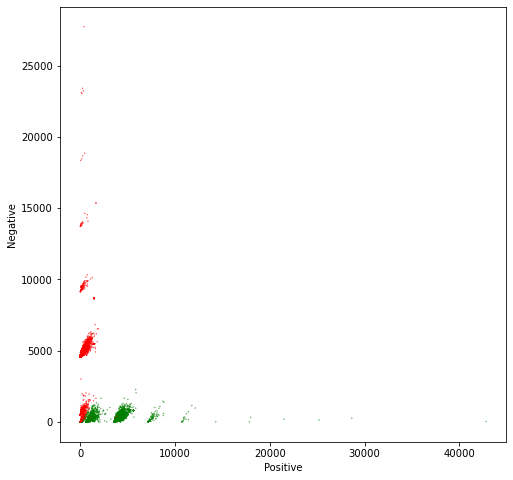

In [26]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

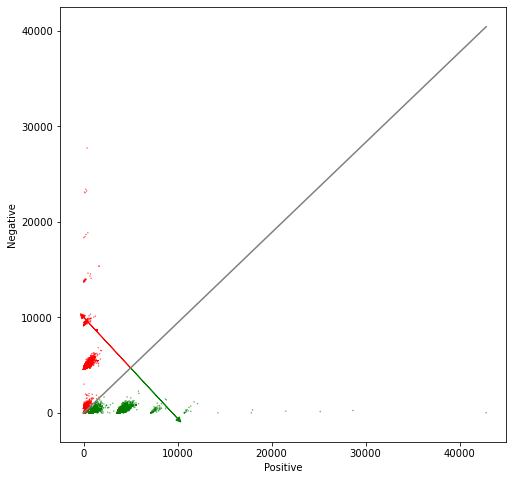

In [28]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])

offset = 5000 # The pos value for the direction vectors origin

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

# Plot a green line pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=500, head_length=500, fc='g', ec='g')
# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500, fc='r', ec='r')

plt.show()